#### Imports

In [1]:
import os
import sys
import pandas as pd
from datetime import timedelta
from auto_ts import auto_timeseries
import numpy as np
import dill
import talib
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import MinMaxScaler

# Verifica la ruta absoluta
ruta = os.path.abspath('/Users/mmarchetta/Desktop/Tesis-2024/data-obtention')
sys.path.append(ruta)

#TODO: eliminar la ejecucion del codigo automaticamente de este file
from dataset_builder import generar_dataset

Importing plotly failed. Interactive plots will not work.


Imported auto_timeseries version:0.0.92. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


#### Lectura del dataset

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [7]:
columns = [
    # 'Open_time',
    'Open',
    'High',
    'Low',
    'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    'Lower_Band',
    'RSI',
    'MACD',
    'Signal',
    'ADX',
    'SlowK',
    'SlowD',
    'CCI',
    'ATR',
    # 'MFI'
]

In [8]:
complete_dataset = pd.read_csv('final_dataset.csv') 

In [9]:
display(complete_dataset.tail())

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral


#### Obtengo la informacion del ultimo dia que paso

In [10]:
ultima_fecha = pd.to_datetime(complete_dataset['Open_time'].iloc[-1])
nueva_fecha = ultima_fecha + pd.Timedelta(days=1)

display(ultima_fecha)
display(nueva_fecha)

Timestamp('2024-06-10 00:00:00')

Timestamp('2024-06-11 00:00:00')

In [11]:
complete_dataset.tail()

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral


#### Obtengo la informacion de ese dia

In [12]:
margin_days = 40
wanted_previous_dates = 1
binance_symbol = 'DOTUSDT'
coinbase_symbol = 'DOT-USD'
interval = '1d'
n_days_to_predict = 10

start_time = int((nueva_fecha - timedelta(days=(margin_days + wanted_previous_dates + 1))).timestamp() * 1000)
end_time = int((nueva_fecha + timedelta(days=(1))).timestamp() * 1000)

start_date = nueva_fecha - timedelta(days=(wanted_previous_dates))
end_date = nueva_fecha + timedelta(days=1)

In [13]:
dataset_nuevo_registro = generar_dataset(interval, start_time, end_time, start_date, end_date, coinbase_symbol, binance_symbol, ['BTCUSDT', 'ETHUSDT', 'BNBUSDT'])

In [14]:
dataset_nuevo_registro['buy_1000x_high_coinbase'] = 0
dataset_nuevo_registro['Cantidad_pos'] = 0
dataset_nuevo_registro['Cantidad_neg'] = 0
dataset_nuevo_registro['Cantidad_neu'] = 0
dataset_nuevo_registro['Compound_total'] = 0
dataset_nuevo_registro['Sentimiento_coin'] = 0
dataset_nuevo_registro['Tweets_Utilizados_coin'] = 0
dataset_nuevo_registro['Cantidad_pos_coin'] = 0
dataset_nuevo_registro['Cantidad_neg_coin'] = 0
dataset_nuevo_registro['Cantidad_neu_coin'] = 0
dataset_nuevo_registro['Compound_total_coin'] = 0
dataset_nuevo_registro['Sentimiento_referentes'] = 0
dataset_nuevo_registro['Tweets_Utilizados_referentes'] = 0
dataset_nuevo_registro['Cantidad_pos_referentes'] = 0
dataset_nuevo_registro['Cantidad_neg_referentes'] = 0
dataset_nuevo_registro['Cantidad_neu_referentes'] = 0
dataset_nuevo_registro['Compound_total_referentes'] = 0
dataset_nuevo_registro['Tweets_Utilizados_whale_alert'] = 0
dataset_nuevo_registro['sell_1000x_high_coinbase'] = 0
dataset_nuevo_registro['total_trades_coinbase'] = 0
dataset_nuevo_registro['Sentimiento'] = 0
dataset_nuevo_registro['Tweets_Utilizados'] = 0
dataset_nuevo_registro['Compound total'] = 0
dataset_nuevo_registro['Compound total coin'] = 0
dataset_nuevo_registro['Compound total referentes'] = 0
dataset_nuevo_registro['Buy_1000x_high'] = 0
dataset_nuevo_registro['Buy_1000x_high'] = 0
dataset_nuevo_registro['total_trades_binance'] = 0
dataset_nuevo_registro['sell_1000x_high'] = 0

In [15]:
ultimo_close = complete_dataset['Close'].iloc[-1]
nuevo_registro = dataset_nuevo_registro[:].iloc[-2] #por algun motivo me trae los datos del dia actual hasta el momento tmb
display(ultimo_close)
display(nuevo_registro)

6.506

Open_time                    2024-06-11 00:00:00
Open                                  6.50600000
High                                  6.52700000
Low                                   6.21700000
Close                                 6.37800000
                                    ...         
Compound total coin                            0
Compound total referentes                      0
Buy_1000x_high                                 0
total_trades_binance                           0
sell_1000x_high                                0
Name: 42, Length: 71, dtype: object

In [16]:
def categorizar_tendencia(cambio):
    if cambio > 0.015:
        return 'Alcista'
    elif -0.015 <= cambio <= 0.015:
        return 'Lateral'
    elif cambio <= -0.015:
        return 'Bajista'

# Calcular el cambio en el precio de cierre entre dos periodos
cambio = float(nuevo_registro['Close']) - ultimo_close
percent_change = cambio / ultimo_close

# Categorizar la tendencia
tendencia = categorizar_tendencia(percent_change)

nuevo_registro['Tendencia'] = tendencia

In [17]:
display(pd.DataFrame(nuevo_registro).T)
nuevo_registro = pd.DataFrame(nuevo_registro).T

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound_total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound_total_coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound_total_referentes,Tweets_Utilizados_whale_alert,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Compound total,Compound total coin,Compound total referentes,Buy_1000x_high,total_trades_binance,sell_1000x_high,Tendencia
42,2024-06-11,6.50600000,6.52700000,6.21700000,6.37800000,5420734.07000000,34467834.53315000,123800,69540.00000000,69590.01000000,66051.00000000,67314.24000000,41436.01588000,2793799020.46912430,1782415,3667.85000000,3673.00000000,3432.00000000,3497.33000000,439568.59780000,1552225947.17115500,1036229,625.10000000,629.00000000,595.80000000,602.50000000,640655.92000000,392329646.87440000,607996,7.03,6.89,7.76,7.03,6.31,37.66,-0.15,-0.05,24.18,25.71,25.99,-122.13,0.35,34.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bajista


In [18]:
complete_dataset.dtypes

Open_time                         object
Open                             float64
High                             float64
Low                              float64
Close                            float64
                                  ...   
Tweets_Utilizados_whale_alert    float64
Buy_1000x_high                   float64
sell_1000x_high                  float64
total_trades_binance             float64
Tendencia                         object
Length: 69, dtype: object

In [19]:
# Acomodo las unidades y el formato de fecha
columns_to_convert = nuevo_registro.columns.difference(['Open_time', 'Tendencia'])
nuevo_registro[columns_to_convert] = nuevo_registro[columns_to_convert].astype(float).round(3)

nuevo_registro['Open_time'] = pd.to_datetime(nuevo_registro['Open_time']).dt.date

display(nuevo_registro)

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound_total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound_total_coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound_total_referentes,Tweets_Utilizados_whale_alert,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Compound total,Compound total coin,Compound total referentes,Buy_1000x_high,total_trades_binance,sell_1000x_high,Tendencia
42,2024-06-11,6.51,6.53,6.22,6.38,5420734.07,34467834.53,123800.00,69540.00,69590.01,66051.00,67314.24,41436.02,2793799020.47,1782415.00,3667.85,3673.00,3432.00,3497.33,439568.60,1552225947.17,1036229.00,625.10,629.00,595.80,602.50,640655.92,392329646.87,607996.00,7.03,6.89,7.76,7.03,6.31,37.66,-0.15,-0.05,24.18,25.71,25.99,-122.13,0.35,34.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Bajista


In [20]:
nuevo_registro.dtypes

Open_time                     object
Open                         float64
High                         float64
Low                          float64
Close                        float64
                              ...   
Compound total referentes    float64
Buy_1000x_high               float64
total_trades_binance         float64
sell_1000x_high              float64
Tendencia                     object
Length: 72, dtype: object

In [21]:
nuevo_df = pd.concat([complete_dataset, nuevo_registro[complete_dataset.columns]], ignore_index=True)
nuevo_df['Open_time'] = pd.to_datetime(nuevo_df['Open_time'])
nuevo_df.to_csv('final_dataset.csv', index=False) 
display(nuevo_df.tail(5))

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral
988,2024-06-11,6.51,6.53,6.22,6.38,5420734.07,34467834.53,123800.00,69540.00,69590.01,66051.00,67314.24,41436.02,2793799020.47,1782415.00,3667.85,3673.00,3432.00,3497.33,439568.60,1552225947.17,1036229.00,625.10,629.00,595.80,602.50,640655.92,392329646.87,607996.00,7.03,6.89,7.76,7.03,6.31,37.66,-0.15,-0.05,24.18,25.71,25.99,-122.13,0.35,34.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Bajista


#### Re-entreno los mejores modelos predictores de features

In [22]:
columns_to_predict = [
    # 'Open_time',
    'Open',
    'High',
    'Low',
    'Close',
]

In [23]:
nuevo_df = pd.read_csv('final_dataset.csv')
features = nuevo_df[columns_to_predict]
features['timestamp'] = pd.to_datetime(nuevo_df['Open_time'])
features = features[['timestamp'] + columns_to_predict]
display(features)

,timestamp,Open,High,Low,Close
0,2021-09-27,28.84,30.26,27.50,27.71
1,2021-09-28,27.72,28.38,26.14,26.31
2,2021-09-29,26.31,28.59,26.11,27.28
3,2021-09-30,27.28,28.99,27.13,28.62
4,2021-10-01,28.61,32.33,28.50,31.94
...,...,...,...,...,...
984,2024-06-07,7.14,7.29,6.05,6.66
985,2024-06-08,6.66,6.68,6.34,6.38
986,2024-06-09,6.38,6.54,6.38,6.53
987,2024-06-10,6.53,6.58,6.36,6.51


In [24]:
features.dtypes

timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
dtype: object

Start of Fit.....
    Target variable given as = Open
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['Open']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (989, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


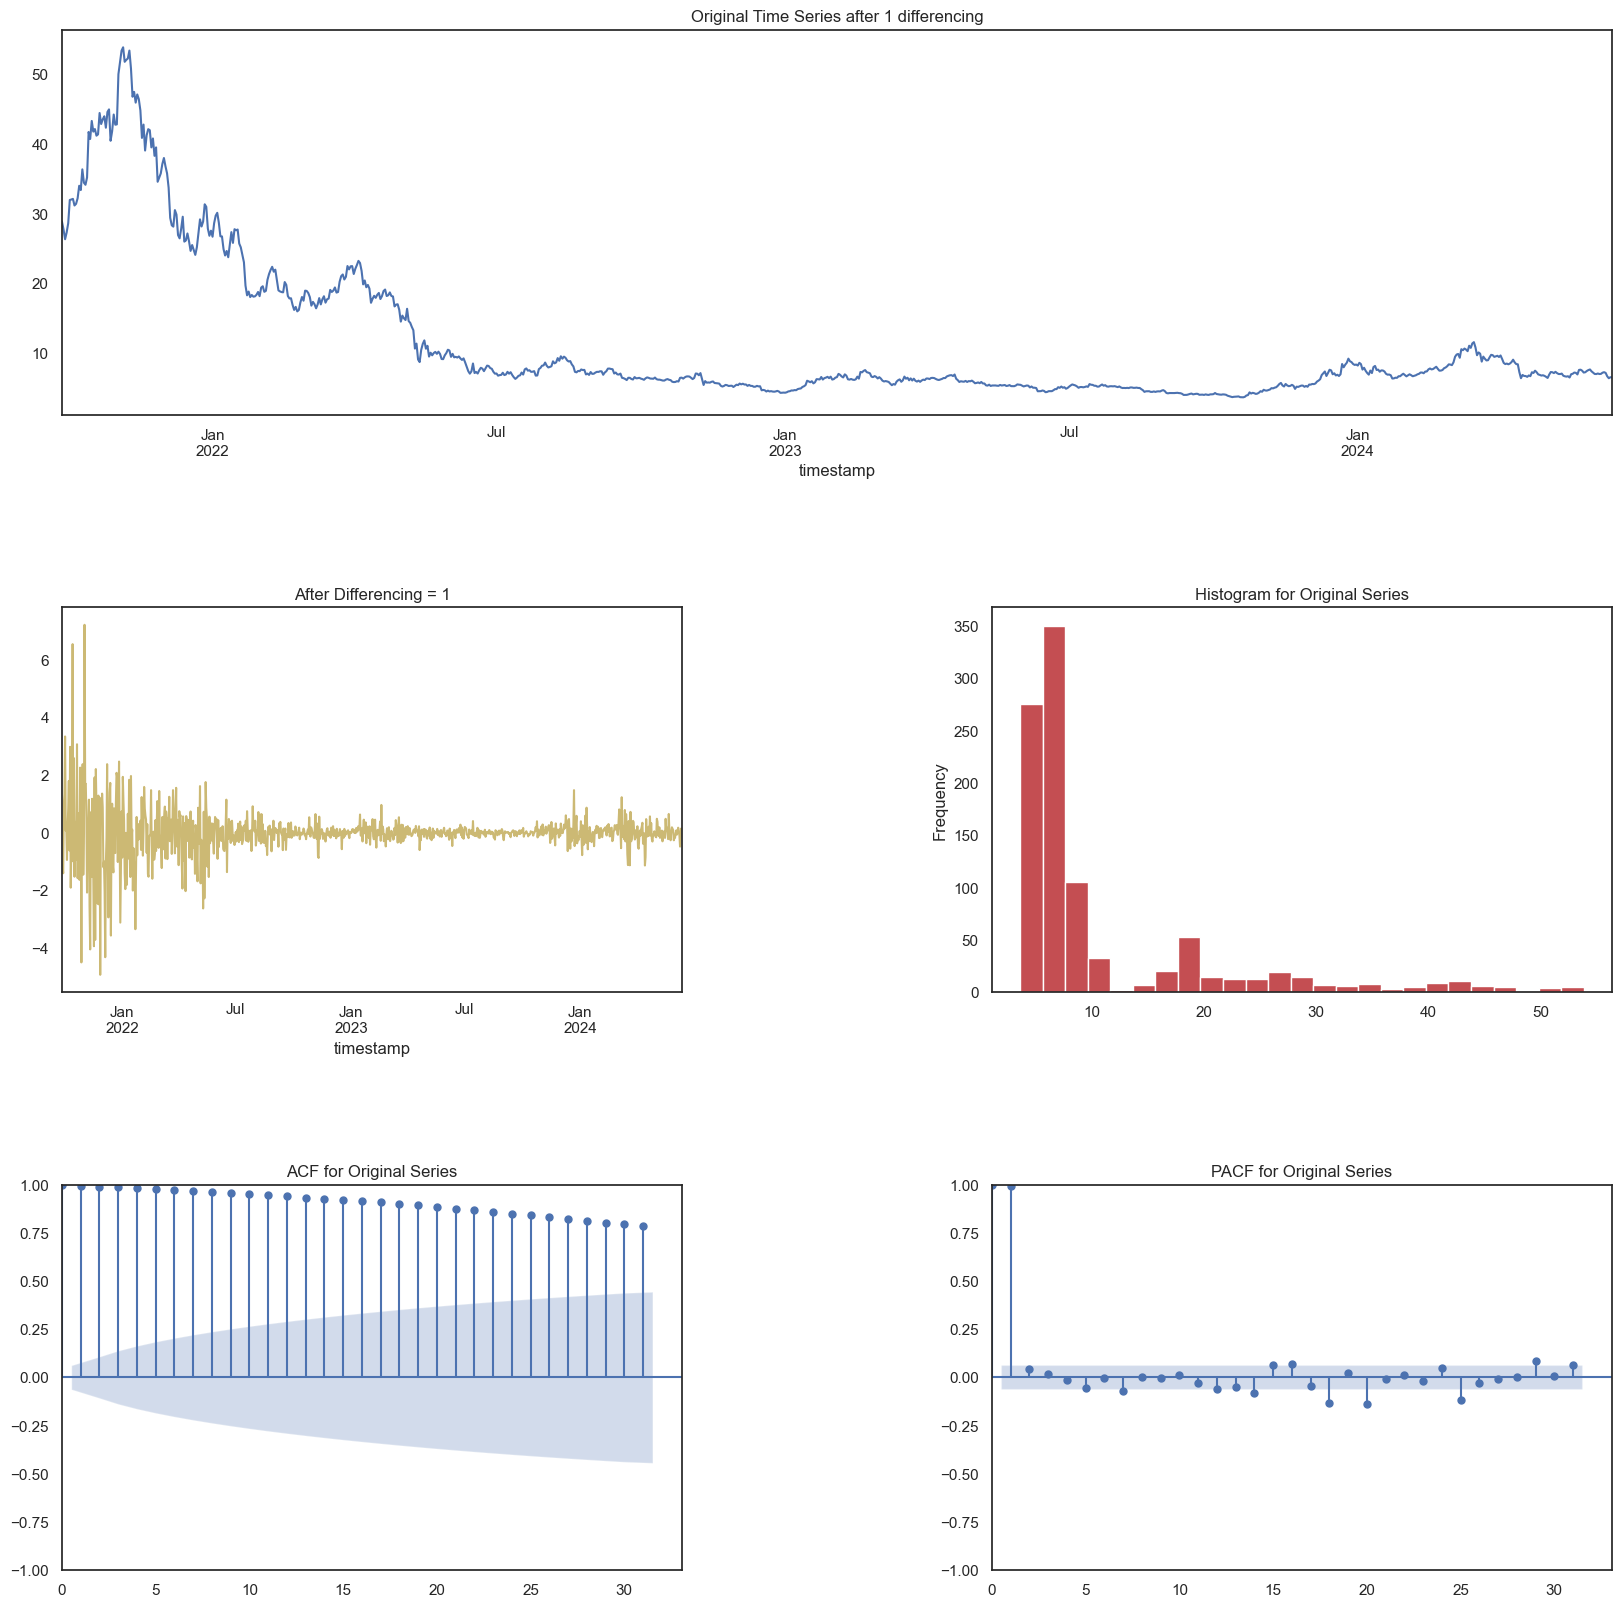

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building VAR Model - best suited for small datasets < 1000 rows and < 10 columns



Running VAR Model...
    Shifting 3 predictors by 1 to align prior predictor values with current target values...

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

Additional Variable in VAR model = High
 Iteration 1 completed
 Iteration 2 completed
 Iteration 3 completed
 Iteration 4 completed
 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 2874.025

Additional Variable in VAR model = Low
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 It

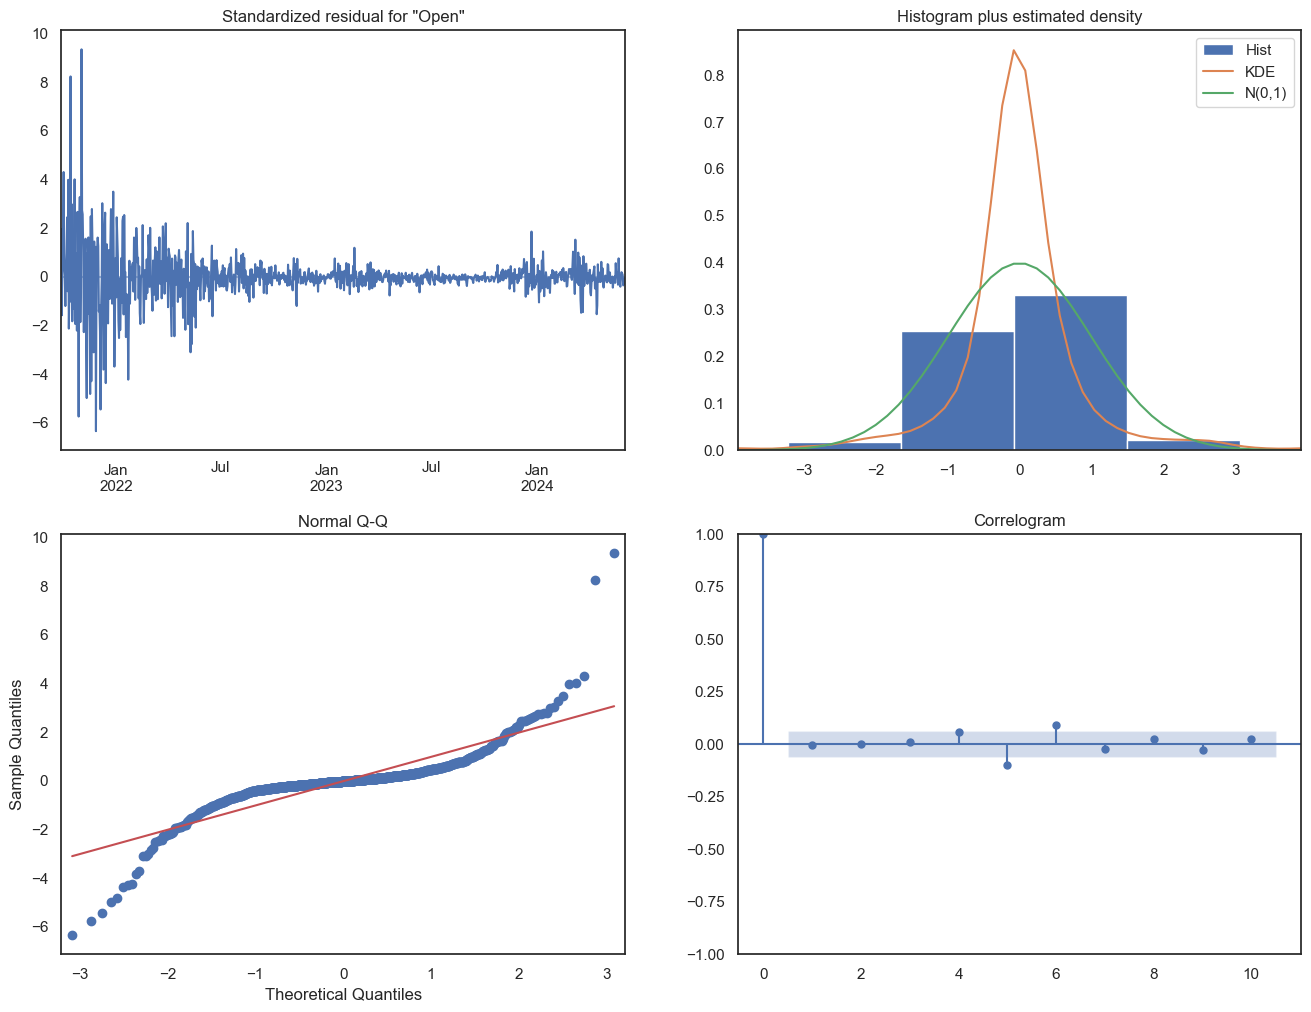

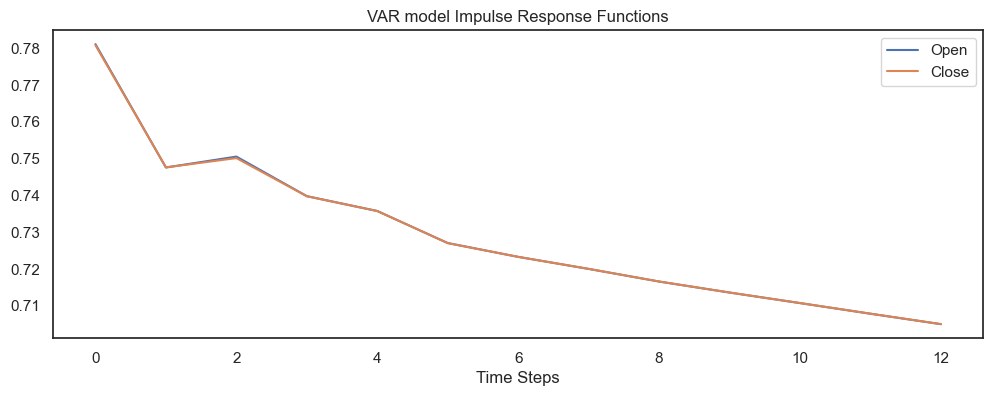

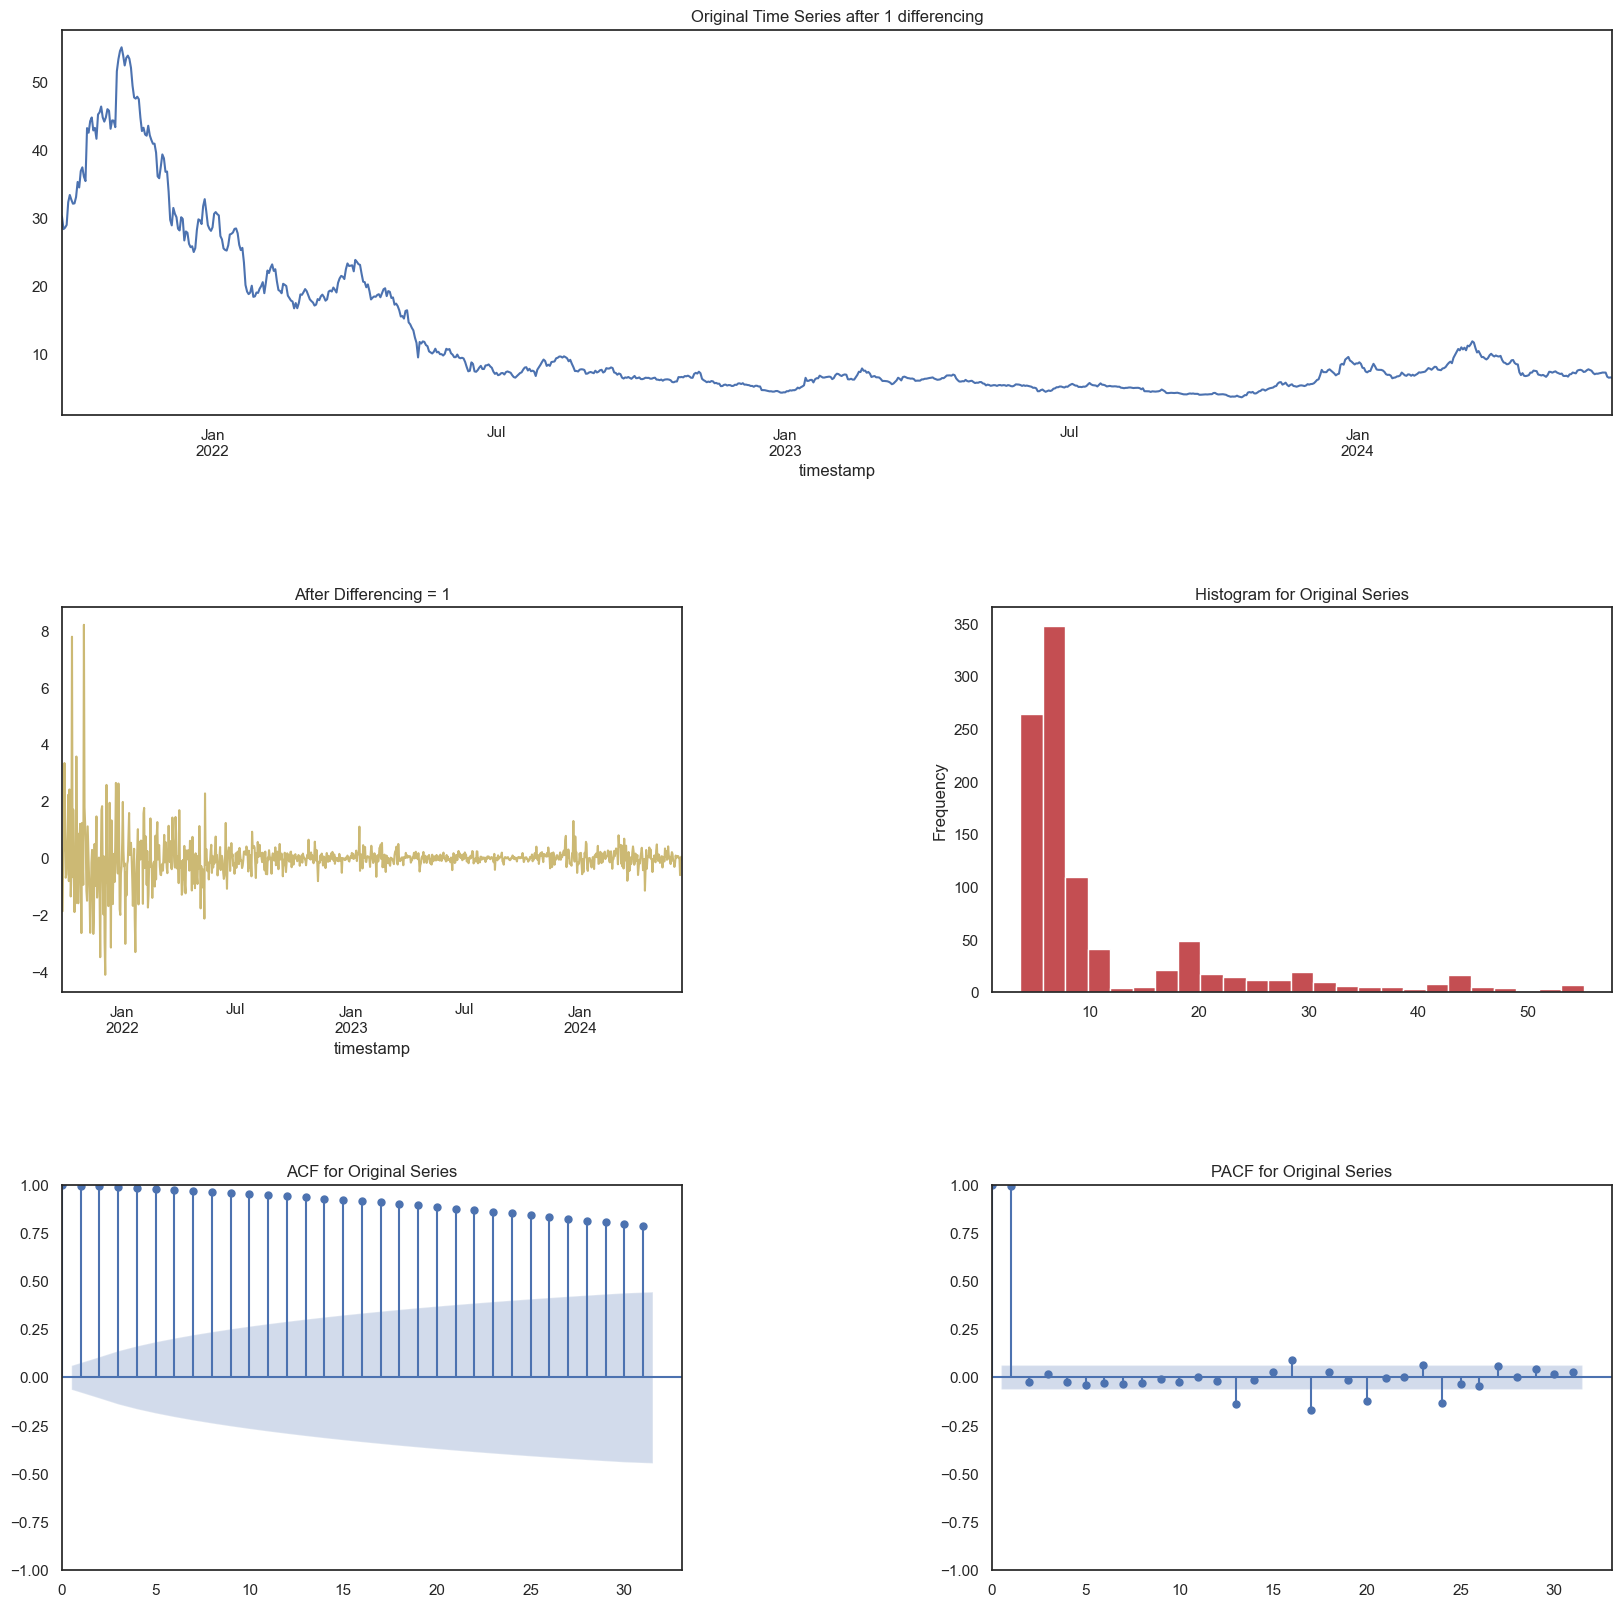

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building VAR Model - best suited for small datasets < 1000 rows and < 10 columns



Running VAR Model...
    Shifting 3 predictors by 1 to align prior predictor values with current target values...

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

Additional Variable in VAR model = Open
 Iteration 1 completed
 Iteration 2 completed
 Iteration 3 completed
 Iteration 4 completed
 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 2870.634

Additional Variable in VAR model = Low
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 It

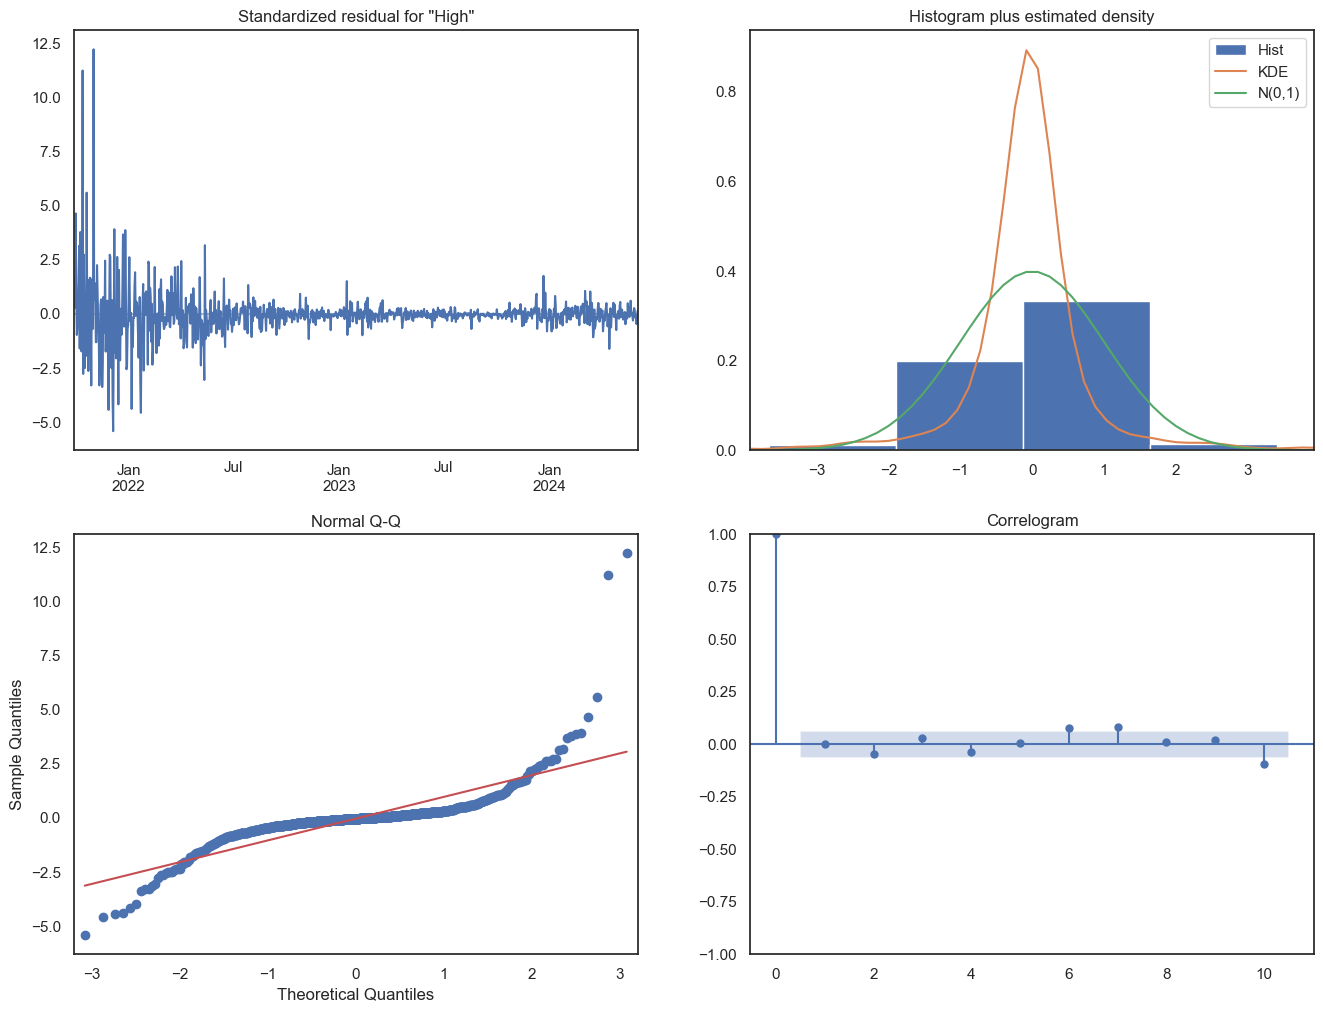

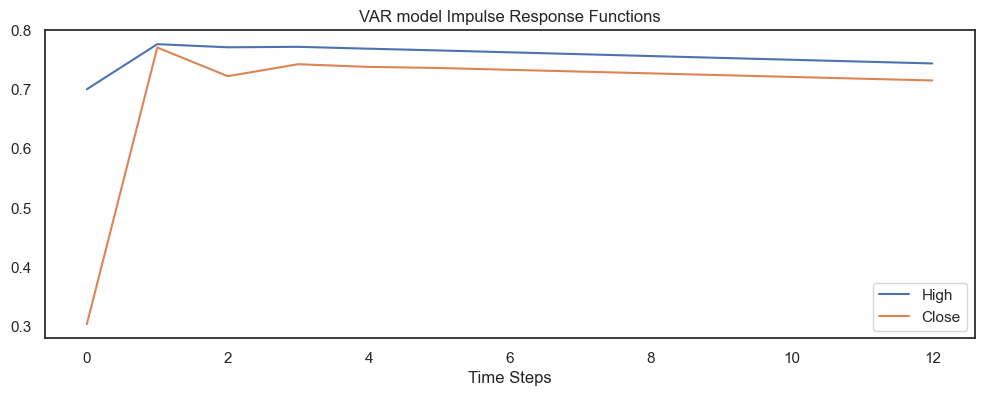

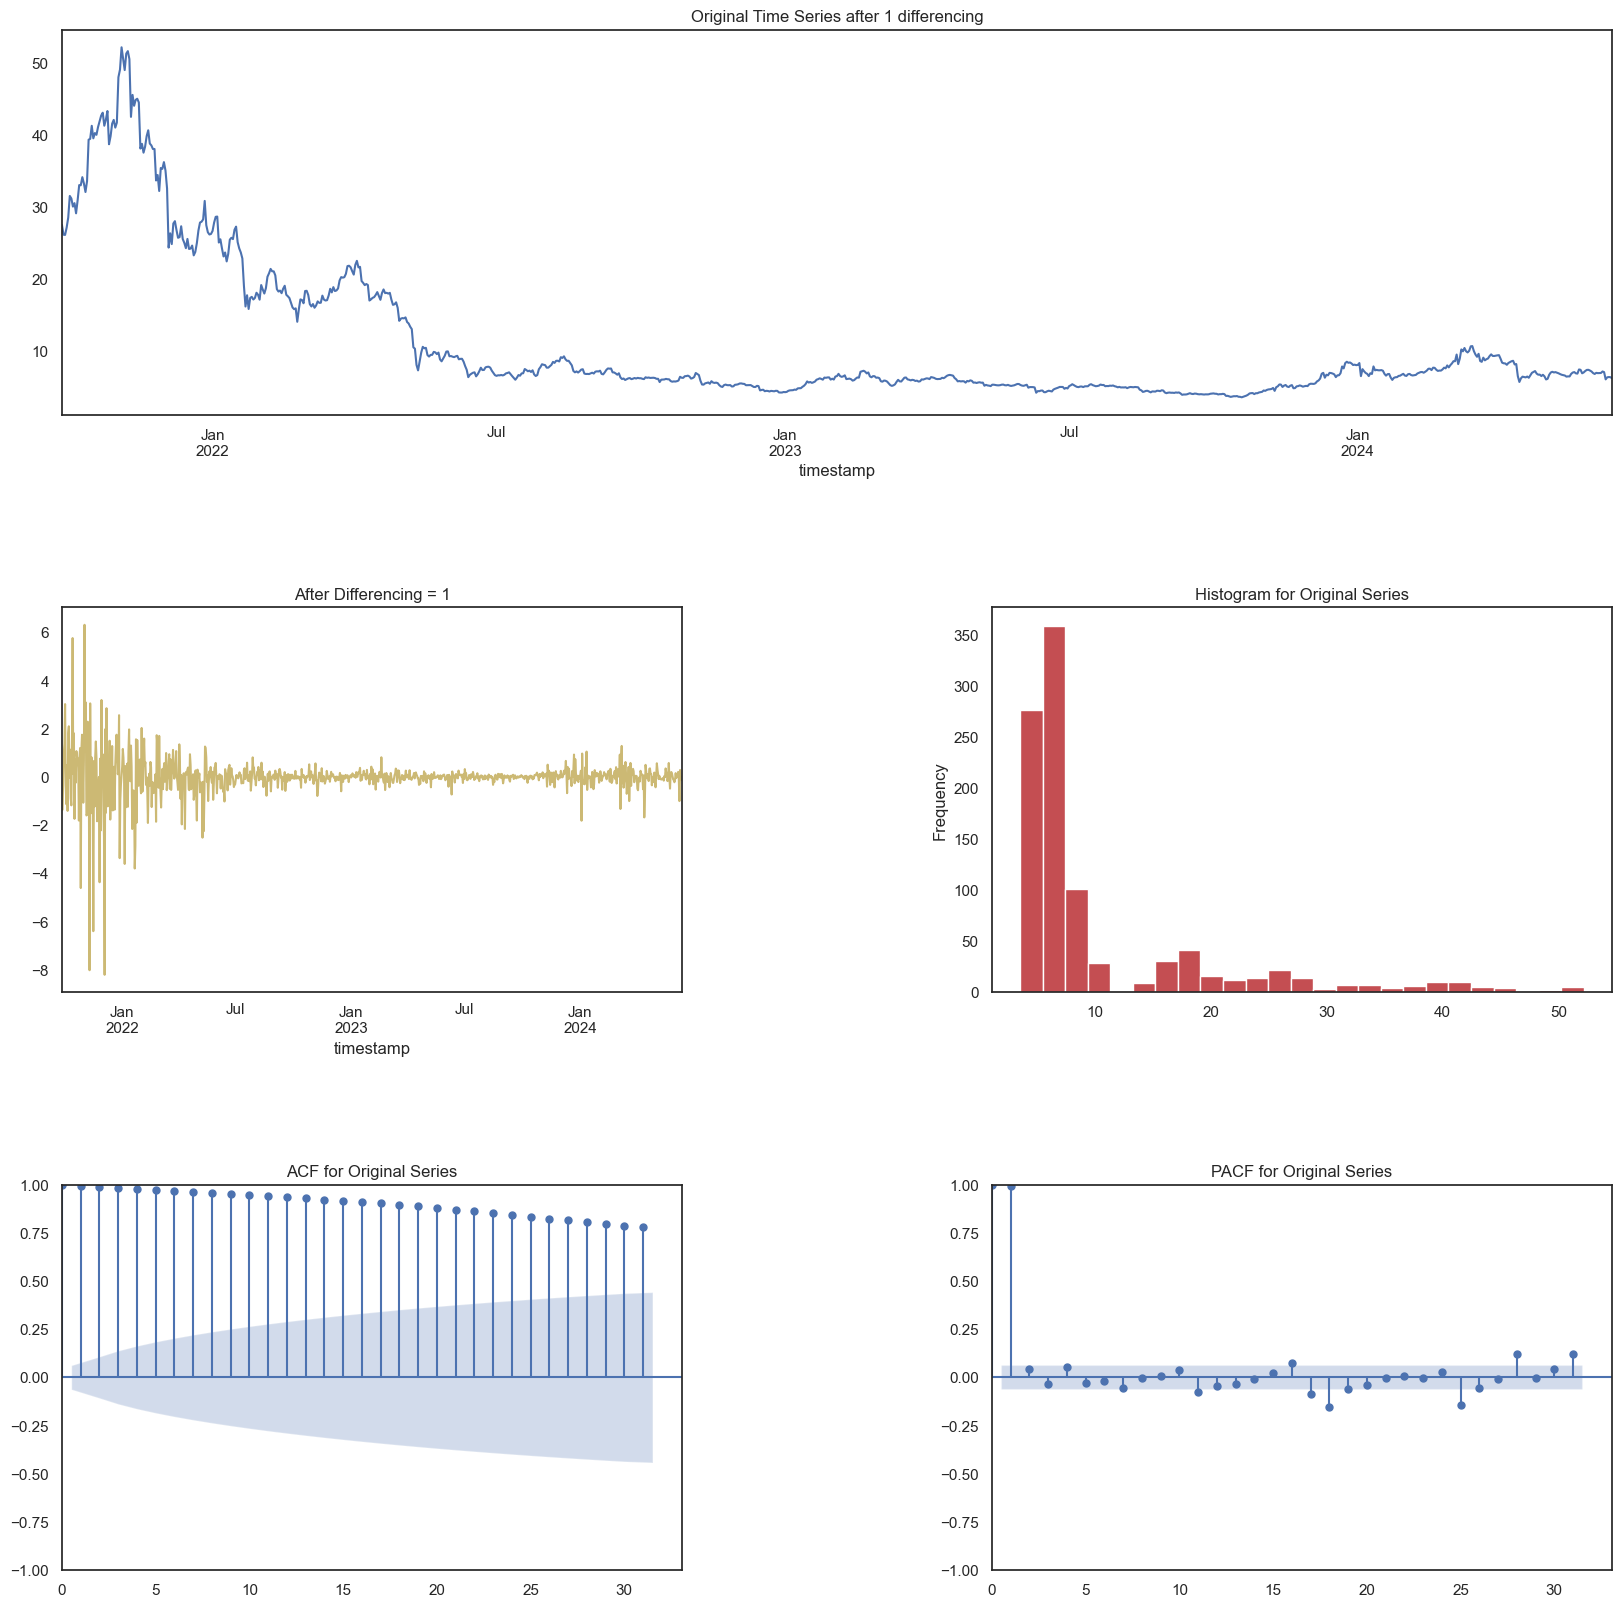

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building VAR Model - best suited for small datasets < 1000 rows and < 10 columns



Running VAR Model...
    Shifting 3 predictors by 1 to align prior predictor values with current target values...

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

Additional Variable in VAR model = Open
 Iteration 1 completed
 Iteration 2 completed
 Iteration 3 completed
 Iteration 4 completed
 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 1, Interim metric = 3318.384

Additional Variable in VAR model = High
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 I

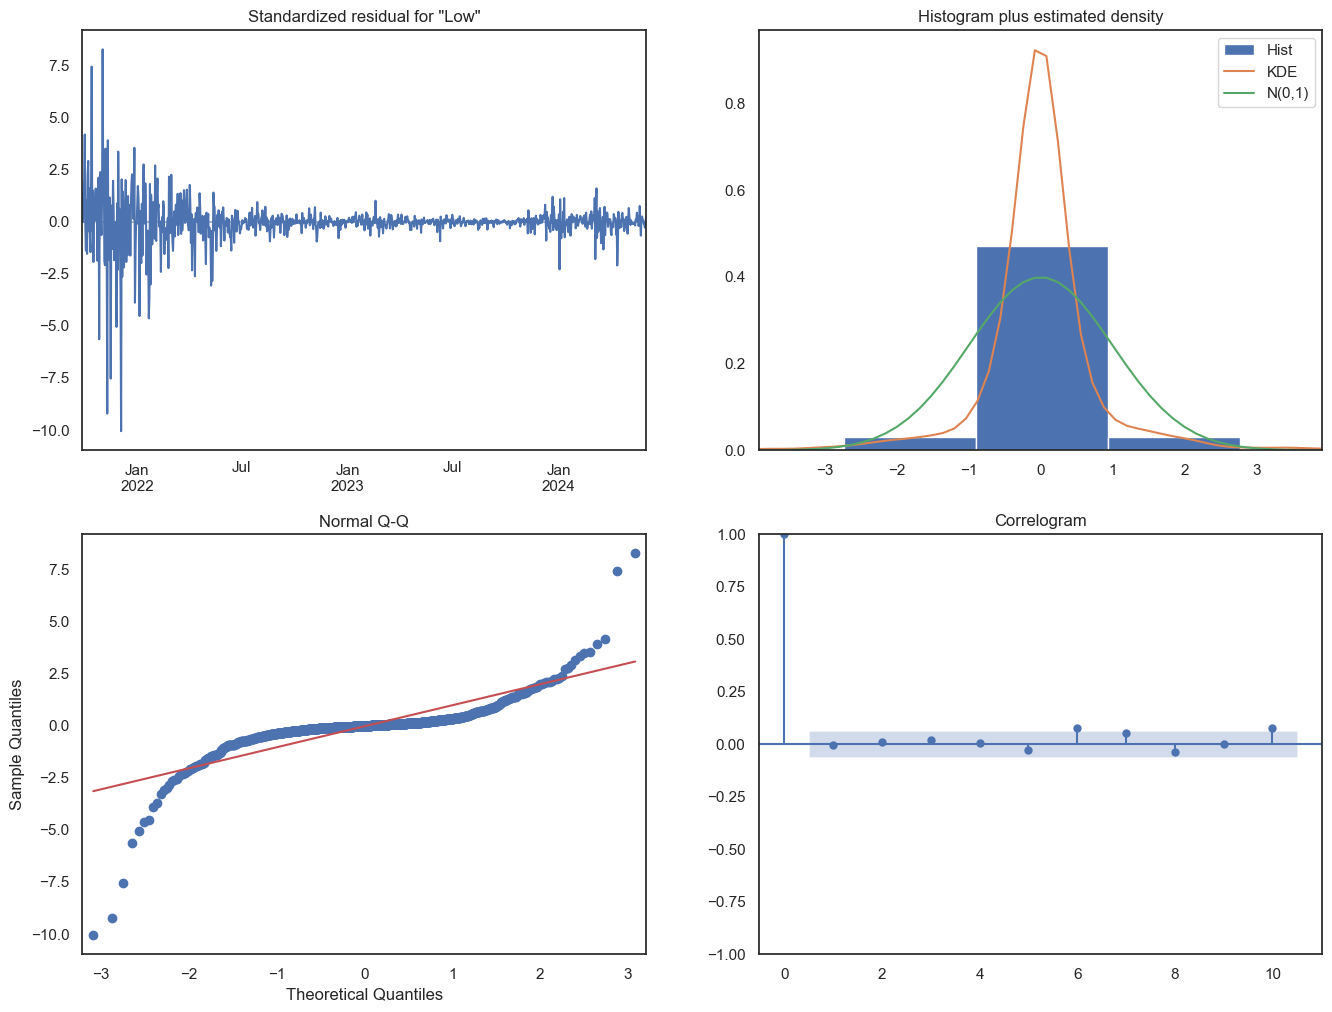

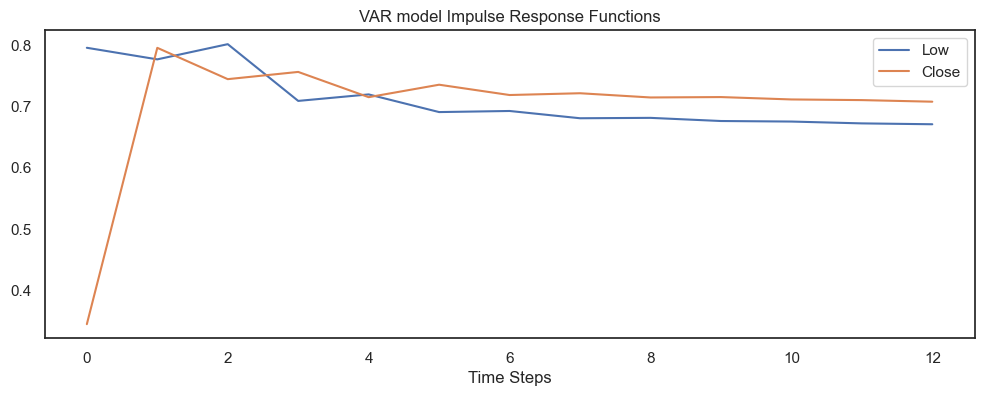

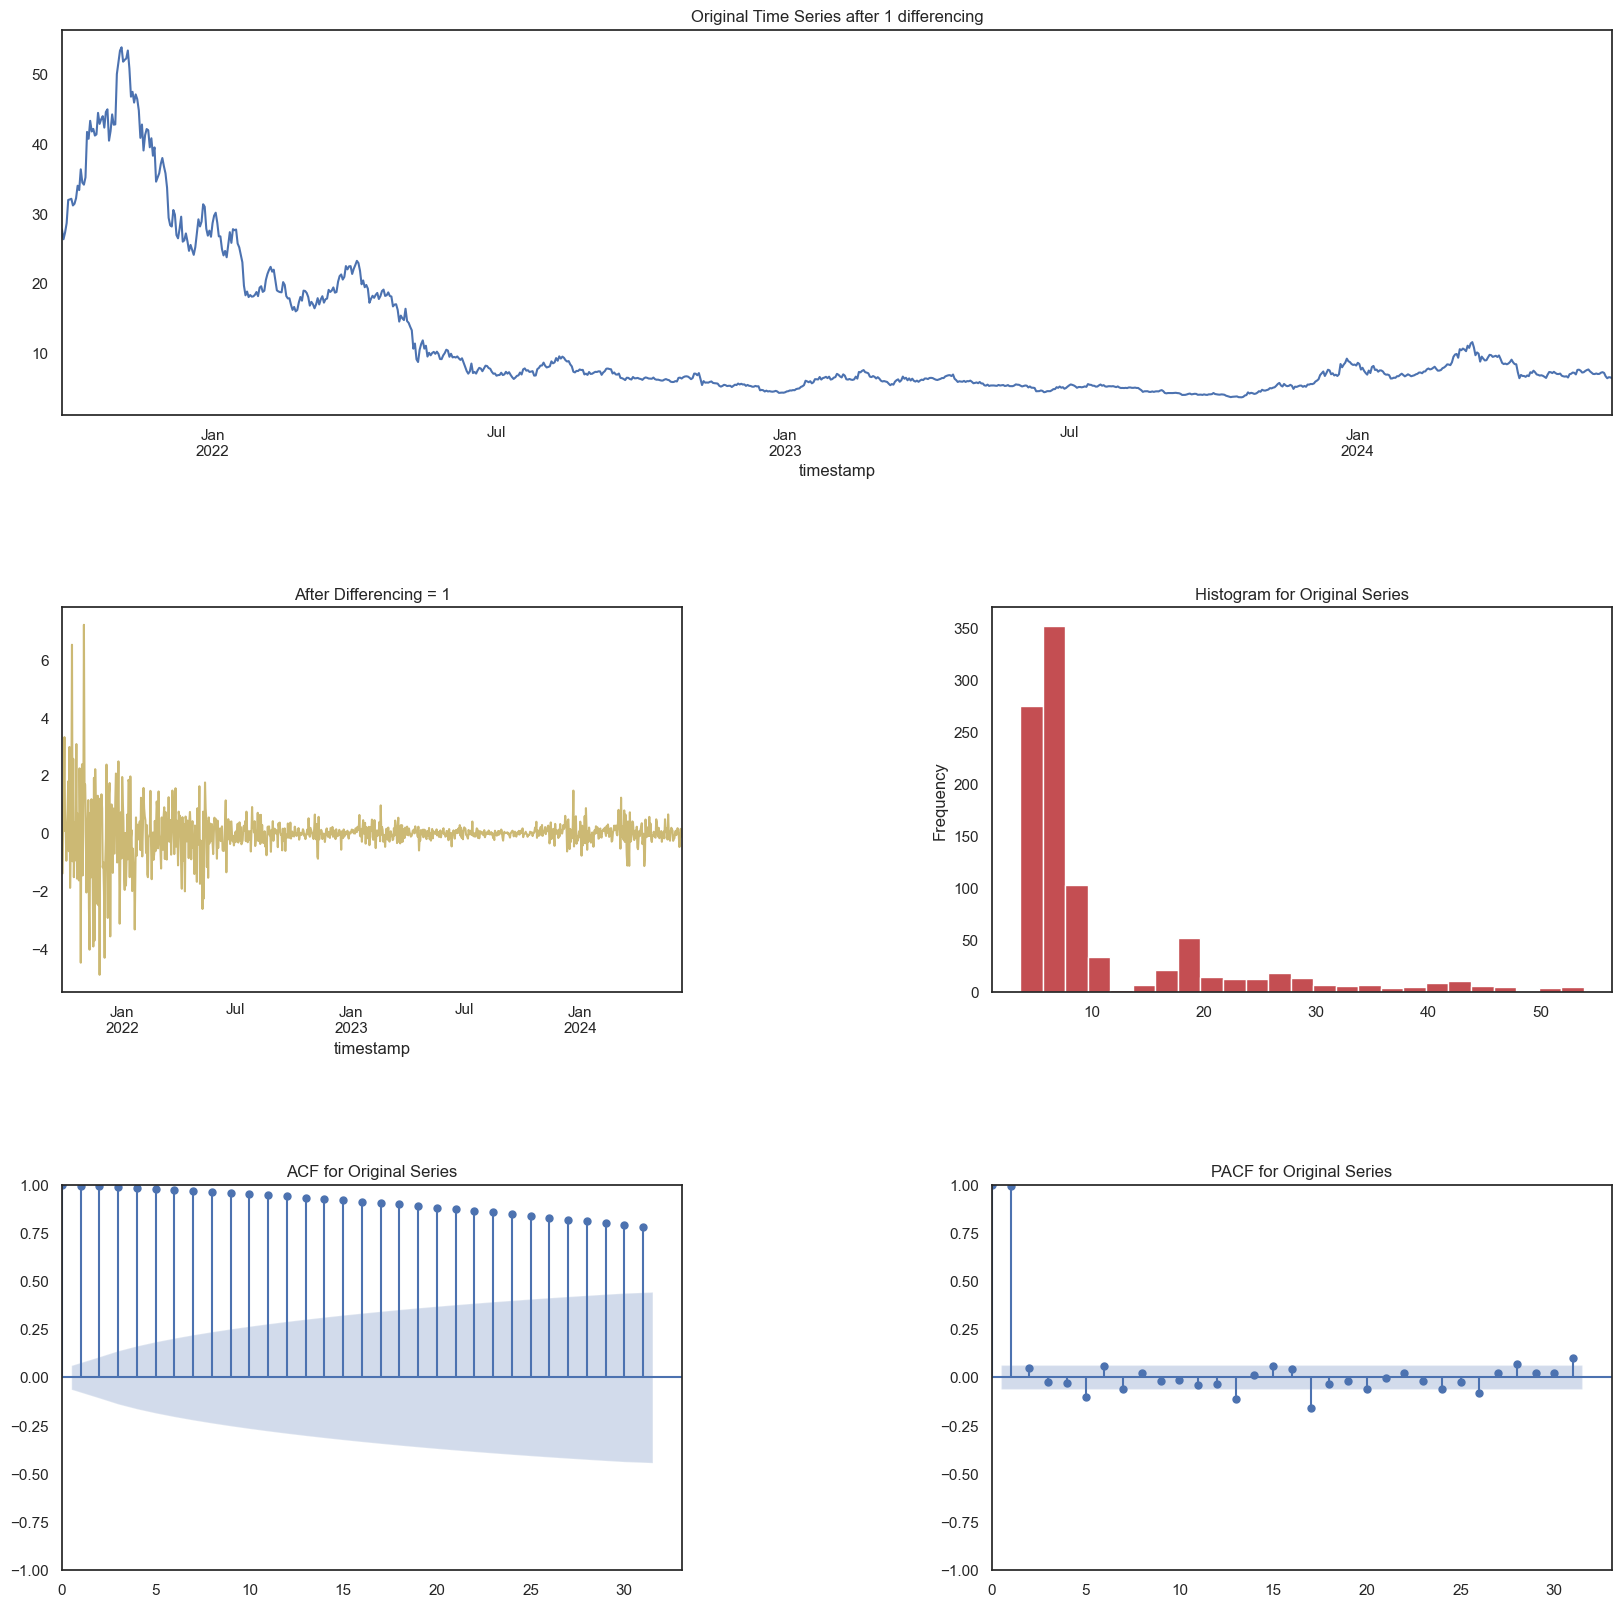

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building VAR Model - best suited for small datasets < 1000 rows and < 10 columns



Running VAR Model...
    Shifting 3 predictors by 1 to align prior predictor values with current target values...

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

Additional Variable in VAR model = Open
 Iteration 1 completed
 Iteration 2 completed
 Iteration 3 completed
 Iteration 4 completed
 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 1, Interim metric = -4955.823

Additional Variable in VAR model = High
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 

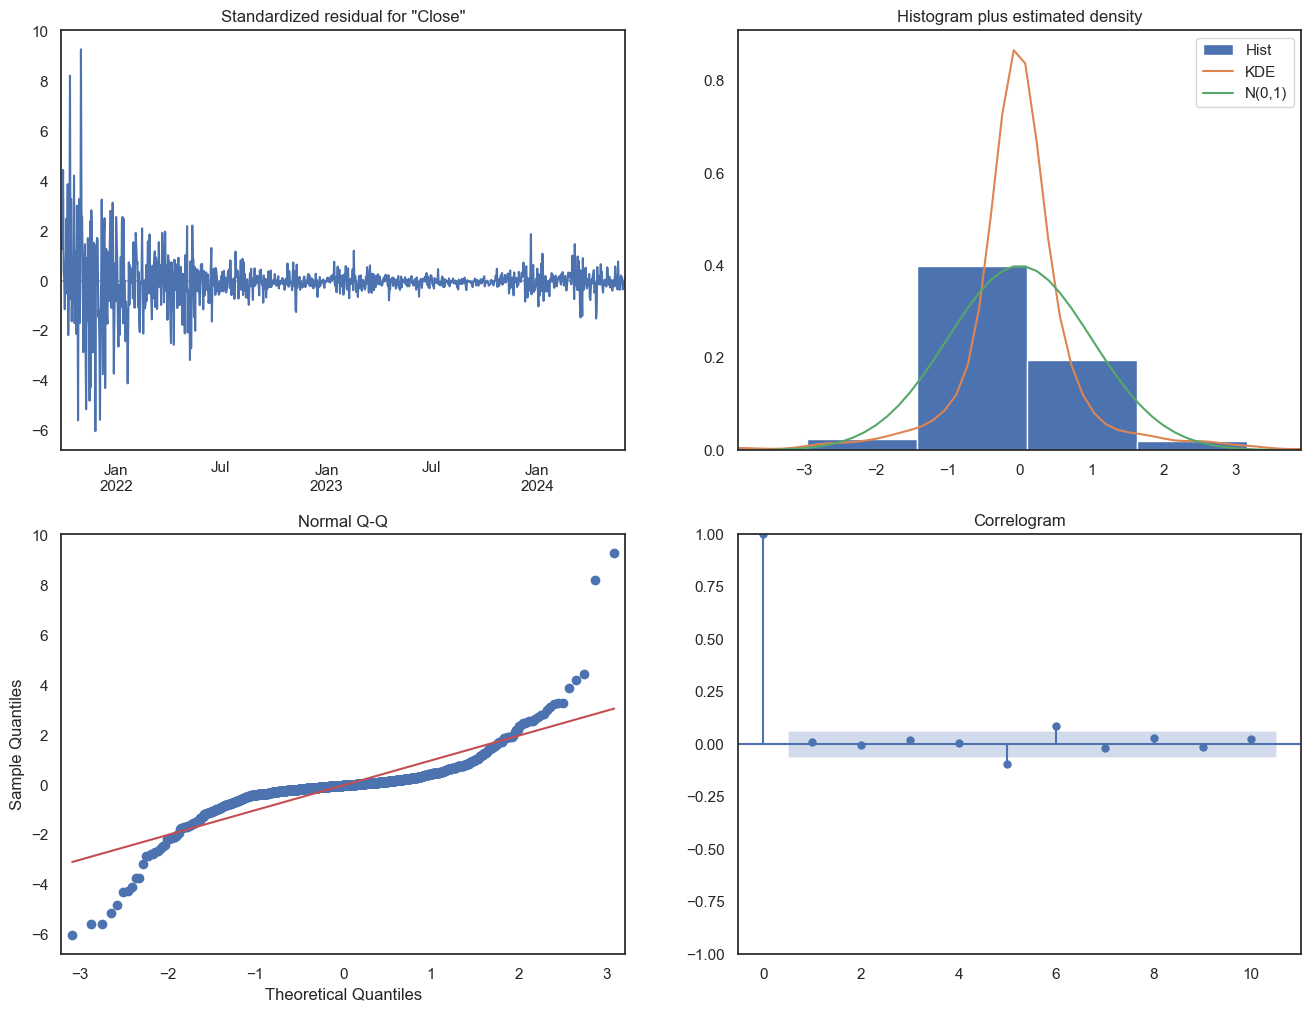

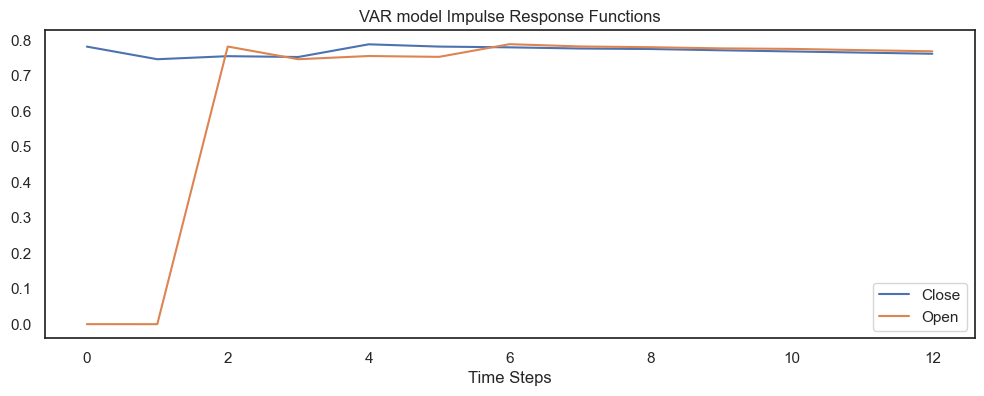

In [93]:
trained_models = {}

cv = 2
# Iterar sobre cada columna seleccionada
for column in columns_to_predict:
    # Excluir 'Open_time' del bucle de iteración
    if column != 'Open_time':
        model = auto_timeseries(score_type='rmse', time_interval='D',
                                non_seasonal_pdq=None, seasonality=False,
                                model_type='var', verbose=2, forecast_period=n_days_to_predict)
        
        model.fit(features, ts_column='timestamp', target=column, cv=cv)
        
        trained_models[column] = model

#### Hago las predicciones a futuro

In [94]:
def calcular_indicadores_tecnicos(historico_precio):
    close_prices = np.array(historico_precio['Close'], dtype=np.double)
    high_prices = np.array(historico_precio['High'], dtype=np.double)
    low_prices = np.array(historico_precio['Low'], dtype=np.double)
    
    # Media Móvil Simple (SMA)
    sma_20 = talib.SMA(close_prices, timeperiod=20)
    
    # Media Móvil Exponencial (EMA)
    ema_20 = talib.EMA(close_prices, timeperiod=20)
    
    # Bandas de Bollinger
    upper_band, middle_band, lower_band = talib.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2)
    
    # Índice de Fuerza Relativa (RSI)
    rsi = talib.RSI(close_prices, timeperiod=14)
    
    # MACD (Convergencia/Divergencia de Medias Móviles)
    macd, signal, _ = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    
    # ADX (Índice Direccional Promedio)
    adx = talib.ADX(high_prices, low_prices, close_prices, timeperiod=14)
    
    # Estocástico
    slowk, slowd = talib.STOCH(high_prices, low_prices, close_prices, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    # Índice de Canal de Materias Primas 
    cci = talib.CCI(high_prices, low_prices, close_prices, timeperiod=14)
    
    # ATR (Average True Range)
    atr = talib.ATR(high_prices, low_prices, close_prices, timeperiod=14)
    
    indicadores = pd.DataFrame({
        'SMA_20': sma_20,
        'EMA_20': ema_20,
        'Upper_Band': upper_band,
        'Middle_Band': middle_band,
        'Lower_Band': lower_band,
        'RSI': rsi,
        'MACD': macd,
        'Signal': signal,
        'ADX': adx,
        'SlowK': slowk,
        'SlowD': slowd,
        'CCI': cci,
        'ATR': atr
    }, index=historico_precio.index)
    
    return indicadores

In [95]:
forecast_results = {}

for column in columns_to_predict:
    future_predictions = trained_models[column].predict(testdata=10)
    forecast_results[column] = future_predictions
    # display(future_predictions)

# Mostrar los resultados del pronóstico
for column, predictions in forecast_results.items():
    print(f"Pronóstico para la columna '{column}':")
    display(pd.DataFrame(predictions))

Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Pronóstico para la columna 'Open':


Open,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-12,6.54,0.78,5.02,8.06
2024-06-13,6.57,1.08,4.46,8.68
2024-06-14,6.59,1.31,4.02,9.16
2024-06-15,6.61,1.51,3.66,9.57
2024-06-16,6.63,1.68,3.34,9.93
2024-06-17,6.65,1.84,3.05,10.25
2024-06-18,6.67,1.98,2.80,10.54
2024-06-19,6.69,2.11,2.56,10.81
2024-06-20,6.70,2.23,2.34,11.07
2024-06-21,6.72,2.34,2.13,11.31


Pronóstico para la columna 'High':


High,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-12,6.51,0.70,5.15,7.88
2024-06-13,6.54,1.04,4.49,8.59
2024-06-14,6.57,1.30,4.02,9.11
2024-06-15,6.60,1.51,3.63,9.56
2024-06-16,6.63,1.70,3.30,9.95
2024-06-17,6.66,1.86,3.01,10.31
2024-06-18,6.69,2.01,2.74,10.63
2024-06-19,6.72,2.15,2.50,10.94
2024-06-20,6.75,2.28,2.27,11.22
2024-06-21,6.78,2.40,2.07,11.49


Pronóstico para la columna 'Low':


Low,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-12,6.19,0.79,4.65,7.74
2024-06-13,6.21,1.11,4.04,8.37
2024-06-14,6.24,1.37,3.56,8.91
2024-06-15,6.25,1.54,3.22,9.28
2024-06-16,6.27,1.71,2.92,9.61
2024-06-17,6.28,1.84,2.67,9.89
2024-06-18,6.30,1.97,2.43,10.16
2024-06-19,6.31,2.09,2.22,10.40
2024-06-20,6.32,2.20,2.02,10.63
2024-06-21,6.34,2.30,1.83,10.85


Pronóstico para la columna 'Close':


Close,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-12,6.38,0.78,4.86,7.91
2024-06-13,6.40,1.08,4.28,8.51
2024-06-14,6.40,1.31,3.83,8.98
2024-06-15,6.40,1.51,3.44,9.37
2024-06-16,6.41,1.71,3.07,9.75
2024-06-17,6.42,1.88,2.74,10.10
2024-06-18,6.43,2.03,2.45,10.41
2024-06-19,6.44,2.17,2.18,10.70
2024-06-20,6.45,2.31,1.93,10.97
2024-06-21,6.45,2.43,1.69,11.22


In [96]:
for column, model in trained_models.items():
    # Guarda el modelo en un archivo usando dill
    with open(f"auto_ts_models/{column}.pkl", "wb") as file:
        dill.dump(model, file)

In [97]:
predictions_df = pd.DataFrame()

for column, predictions in forecast_results.items():
    predictions_df[column] = predictions['yhat'].values

fechas = [nueva_fecha + timedelta(days=i) for i in range(1, 11)]
df_fechas = pd.DataFrame({'timestamp': fechas})

# Añadir la columna de timestamp
predictions_df['Open_time'] = df_fechas['timestamp'].values

display(predictions_df)

,Open,High,Low,Close,Open_time
0,6.54,6.51,6.19,6.38,2024-06-12
1,6.57,6.54,6.21,6.40,2024-06-13
2,6.59,6.57,6.24,6.40,2024-06-14
3,6.61,6.60,6.25,6.40,2024-06-15
4,6.63,6.63,6.27,6.41,2024-06-16
5,6.65,6.66,6.28,6.42,2024-06-17
6,6.67,6.69,6.30,6.43,2024-06-18
7,6.69,6.72,6.31,6.44,2024-06-19
8,6.70,6.75,6.32,6.45,2024-06-20
9,6.72,6.78,6.34,6.45,2024-06-21


In [98]:
nuevo_df.tail()

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral
988,2024-06-11,6.51,6.53,6.22,6.38,5420734.07,34467834.53,123800.00,69540.00,69590.01,66051.00,67314.24,41436.02,2793799020.47,1782415.00,3667.85,3673.00,3432.00,3497.33,439568.60,1552225947.17,1036229.00,625.10,629.00,595.80,602.50,640655.92,392329646.87,607996.00,7.03,6.89,7.76,7.03,6.31,37.66,-0.15,-0.05,24.18,25.71,25.99,-122.13,0.35,34.18,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Bajista


In [99]:
final_df = pd.concat([nuevo_df[['Open_time'] + columns_to_predict], predictions_df], ignore_index=True)

In [100]:
final_df['Open_time'] = pd.to_datetime(final_df['Open_time']).dt.date
display(final_df.tail(15))

,Open_time,Open,High,Low,Close
984,2024-06-07,7.14,7.29,6.05,6.66
985,2024-06-08,6.66,6.68,6.34,6.38
986,2024-06-09,6.38,6.54,6.38,6.53
987,2024-06-10,6.53,6.58,6.36,6.51
988,2024-06-11,6.51,6.53,6.22,6.38
989,2024-06-12,6.54,6.51,6.19,6.38
990,2024-06-13,6.57,6.54,6.21,6.40
991,2024-06-14,6.59,6.57,6.24,6.40
992,2024-06-15,6.61,6.60,6.25,6.40
993,2024-06-16,6.63,6.63,6.27,6.41


In [101]:
indicadores_tecnicos = calcular_indicadores_tecnicos(final_df)
display(indicadores_tecnicos)

,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.73,6.67,7.40,6.73,6.07,37.47,-0.21,-0.18,28.60,28.84,28.37,-39.45,0.35
995,6.70,6.65,7.34,6.70,6.05,37.86,-0.20,-0.18,28.78,29.52,28.90,-28.64,0.35
996,6.67,6.63,7.31,6.67,6.03,38.26,-0.19,-0.19,28.72,30.25,29.54,-8.48,0.36
997,6.64,6.61,7.27,6.64,6.01,38.71,-0.18,-0.19,28.46,30.99,30.26,62.74,0.36


In [102]:
ultimos_indicadores = indicadores_tecnicos.tail(10)
ultimos_indicadores = ultimos_indicadores.reset_index(drop=True)
merged_last_10 = pd.concat([predictions_df, ultimos_indicadores], axis=1)
display(merged_last_10)

,Open,High,Low,Close,Open_time,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR
0,6.54,6.51,6.19,6.38,2024-06-12,6.99,6.85,7.76,6.99,6.22,36.07,-0.20,-0.11,24.03,25.37,25.34,-102.29,0.35
1,6.57,6.54,6.21,6.40,2024-06-13,6.95,6.80,7.76,6.95,6.15,36.49,-0.21,-0.13,25.47,25.20,25.43,-83.50,0.35
2,6.59,6.57,6.24,6.40,2024-06-14,6.90,6.77,7.71,6.90,6.09,36.71,-0.21,-0.15,26.65,27.37,25.98,-68.89,0.35
3,6.61,6.60,6.25,6.40,2024-06-15,6.84,6.73,7.62,6.84,6.07,36.77,-0.21,-0.16,27.55,27.92,26.83,-58.75,0.35
4,6.63,6.63,6.27,6.41,2024-06-16,6.78,6.70,7.48,6.78,6.08,37.11,-0.21,-0.17,28.20,28.35,27.88,-48.90,0.35
5,6.65,6.66,6.28,6.42,2024-06-17,6.73,6.67,7.40,6.73,6.07,37.47,-0.21,-0.18,28.60,28.84,28.37,-39.45,0.35
6,6.67,6.69,6.30,6.43,2024-06-18,6.70,6.65,7.34,6.70,6.05,37.86,-0.20,-0.18,28.78,29.52,28.90,-28.64,0.35
7,6.69,6.72,6.31,6.44,2024-06-19,6.67,6.63,7.31,6.67,6.03,38.26,-0.19,-0.19,28.72,30.25,29.54,-8.48,0.36
8,6.70,6.75,6.32,6.45,2024-06-20,6.64,6.61,7.27,6.64,6.01,38.71,-0.18,-0.19,28.46,30.99,30.26,62.74,0.36
9,6.72,6.78,6.34,6.45,2024-06-21,6.61,6.60,7.21,6.61,6.01,39.19,-0.17,-0.18,28.00,35.81,32.35,118.93,0.37


In [108]:
merged_last_10.to_csv('auto_ts_models/result.csv', index=False)

#### Clasificacion

In [104]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,22 hours 3 mins
H2O_cluster_timezone:,America/Argentina/Buenos_Aires
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_mmarchetta_2j4nwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.336 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [105]:
stack_models = []
for i in range(5):
    model_path = f"automl_classifier/modelo_{i}.h2o"
    model = h2o.load_model(model_path)
    stack_models.append(model)

In [106]:
scaler = MinMaxScaler()
scaler.fit_transform(nuevo_df[columns])

array([[0.50200275, 0.51720786, 0.49257171, ..., 0.32081933, 0.39135415,
        0.97743099],
       [0.47968355, 0.48065332, 0.46458702, ..., 0.21571971, 0.353492  ,
        0.9457871 ],
       [0.45158526, 0.48473654, 0.46396971, ..., 0.14173471, 0.38052016,
        0.92071527],
       ...,
       [0.0545027 , 0.05599844, 0.05788304, ..., 0.30049182, 0.27026105,
        0.06282378],
       [0.05735238, 0.05681509, 0.05751265, ..., 0.24833548, 0.32459604,
        0.06004891],
       [0.0569339 , 0.05574567, 0.05463188, ..., 0.23281317, 0.33277021,
        0.05879131]])

In [107]:
auto_ml_feature_predictor_df = pd.read_csv('auto_ts_models/result.csv')


features = auto_ml_feature_predictor_df[columns]
features_scaled = scaler.transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=columns)
h2o_df = h2o.H2OFrame(features_scaled)
predictions = stack_models[0].predict(h2o_df)

display(predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,Alcista,Bajista,Lateral
Bajista,0.00697693,0.968129,0.0248937
Bajista,0.00566162,0.980541,0.0137976
Bajista,0.00639781,0.97344,0.0201619
Bajista,0.00649491,0.974748,0.0187575
Bajista,0.00930694,0.971903,0.0187896
Bajista,0.00528063,0.979506,0.015213
Bajista,0.007759,0.963413,0.028828
Bajista,0.00764264,0.96144,0.0309171
Bajista,0.0053089,0.98563,0.00906065
Bajista,0.00579463,0.983931,0.0102741
